# Data Understanding for Europe Base Port Container Price Prediction

This notebook explores and analyzes the data we collected to understand its patterns, trends, seasonality, and characteristics. This step is crucial before building any prediction model for 1-week ahead Europe Base Port price forecasting.

## What is data understanding?

Data understanding (also called Exploratory Data Analysis or EDA) is the process of examining data to discover patterns, spot anomalies, test hypotheses, and check assumptions. Think of it as getting to know your data before you start working with it. Just like you would taste ingredients before cooking, we examine data before modeling.

## Our Focus

**Target**: Europe Base Port prices (Shanghai to Rotterdam/Hamburg/London/Antwerp)

**Key Analyses**:
- Seasonal patterns and their price impacts
- Historical trends and volatility
- Black swan event detection and impact quantification
- Correlation with external factors (oil prices, news volume)

## Why is this important?

Understanding our data helps us make better decisions about which models to use and how to prepare the data. It also helps us identify problems early, like missing values or unusual patterns that might affect our predictions. For our 1-week ahead forecasting, understanding seasonality is particularly crucial.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Understanding the new libraries

matplotlib: A library for creating static, animated, and interactive visualizations. We use it to make charts and graphs.

seaborn: Built on top of matplotlib, it makes creating attractive statistical graphics easier. It is like matplotlib with better default styles.

statsmodels: A library for statistical modeling and testing. We use it to analyze time series data and test statistical properties.

What is time series data? Data that is collected over time at regular intervals, like weekly prices or daily temperatures. Our container prices are time series data because they are recorded each week.

## Step 1: Load the collected data

We will load the datasets we saved in the previous notebook.

In [2]:
# Load freight data
try:
    df_freight = pd.read_csv('collected_freight_data.csv', parse_dates=['Date'], index_col='Date')
    print(f"Loaded freight data: {len(df_freight)} rows")
    print(f"Date range: {df_freight.index.min().strftime('%Y-%m-%d')} to {df_freight.index.max().strftime('%Y-%m-%d')}")
except FileNotFoundError:
    print("Error: 'collected_freight_data.csv' not found.")
    print("Please run the data collection notebook first.")

# Load oil data if it exists
try:
    df_oil = pd.read_csv('collected_oil_data.csv', index_col=0, parse_dates=True)
    df_oil.index.name = 'Date'  # Rename index to 'Date' for clarity
    print(f"\nLoaded oil data: {len(df_oil)} rows")
    has_oil = True
except FileNotFoundError:
    print("\nNo oil data file found.")
    df_oil = pd.DataFrame()
    has_oil = False

# Load GDELT disruption data (weekly geopolitical events)
try:
    df_news = pd.read_csv('collected_news_data.csv', parse_dates=['date'], index_col='date')
    print(f"\nLoaded GDELT disruption data: {len(df_news)} weekly records")
    print(f"Features: {', '.join(df_news.columns.tolist())}")
    has_news = True
except FileNotFoundError:
    print("\nNo GDELT disruption data file found.")
    df_news = pd.DataFrame()
    has_news = False

Loaded freight data: 385 rows
Date range: 2018-01-05 to 2025-08-22

Loaded oil data: 2787 rows

Loaded GDELT disruption data: 412 weekly records
Features: disruption_index, tone, conflict_count, severe_event_count, media_mentions


## Step 2: Basic data inspection

Let's look at the basic properties of our data to understand its structure.

### What is data shape?

The shape tells us how many rows and columns are in our dataset. Rows usually represent observations (like weekly prices), and columns represent variables (like price and index values).

### What are data types?

Each column has a data type that tells us what kind of values it contains. Common types include integers (whole numbers), floats (decimal numbers), strings (text), and datetime (dates and times).

In [3]:
print("=== Freight Data Information ===")
print(f"\nShape: {df_freight.shape[0]} rows, {df_freight.shape[1]} columns")
print(f"\nColumn names: {df_freight.columns.tolist()}")
print(f"\nData types:")
print(df_freight.dtypes)
print(f"\nFirst few rows:")
print(df_freight.head())
print(f"\nLast few rows:")
print(df_freight.tail())

=== Freight Data Information ===

Shape: 385 rows, 2 columns

Column names: ['SCFI_Index', 'Europe_Base_Price']

Data types:
SCFI_Index           float64
Europe_Base_Price      int64
dtype: object

First few rows:
            SCFI_Index  Europe_Base_Price
Date                                     
2018-01-05      816.58                888
2018-01-12      839.72                897
2018-01-19      840.36                891
2018-01-26      858.60                907
2018-02-02      883.59                912

Last few rows:
            SCFI_Index  Europe_Base_Price
Date                                     
2025-07-25     1592.59               2090
2025-08-01     1550.74               2051
2025-08-08     1489.68               1961
2025-08-15     1460.19               1820
2025-08-22     1415.36               1668


## Step 3: Descriptive statistics

Descriptive statistics summarize the main characteristics of our data using numbers.

### What do these statistics mean?

count: How many non-missing values we have.

mean: The average value. Add all values together and divide by the count.

std: Standard deviation. It measures how spread out the values are from the mean. A larger standard deviation means more variability.

min: The smallest value in the data.

25%, 50%, 75%: These are quartiles. The 50% mark is the median (the middle value). The 25% and 75% marks show us where the lower and upper quarters of our data fall.

max: The largest value in the data.

In [4]:
print("=== Descriptive Statistics ===")
print(df_freight.describe())

# Additional insights
print("\n=== Additional Insights ===")
for col in df_freight.columns:
    print(f"\n{col}:")
    print(f"  Range: {df_freight[col].min():.2f} to {df_freight[col].max():.2f}")
    print(f"  Average: {df_freight[col].mean():.2f}")
    print(f"  Variability (std): {df_freight[col].std():.2f}")

=== Descriptive Statistics ===
        SCFI_Index  Europe_Base_Price
count   385.000000         385.000000
mean   1928.988701        2481.802597
std    1307.269171        2258.170409
min     646.590000         562.000000
25%     901.660000         831.000000
50%    1340.930000        1124.000000
75%    2721.940000        3876.000000
max    5109.600000        7797.000000

=== Additional Insights ===

SCFI_Index:
  Range: 646.59 to 5109.60
  Average: 1928.99
  Variability (std): 1307.27

Europe_Base_Price:
  Range: 562.00 to 7797.00
  Average: 2481.80
  Variability (std): 2258.17


## Step 4: Check for missing values

Missing values are gaps in our data where we expected a value but do not have one. They can occur for various reasons, like data entry errors or system failures.

### Why are missing values a problem?

Most machine learning models cannot work with missing values directly. We need to either remove rows with missing values or fill them in (a process called imputation). Understanding where and how many missing values we have helps us decide the best approach.

In [5]:
print("=== Missing Values Analysis ===")
missing_count = df_freight.isnull().sum()
missing_percent = (missing_count / len(df_freight)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Percentage': missing_percent
})

print(missing_df)

if missing_count.sum() == 0:
    print("\nGood news! No missing values found in the freight data.")
else:
    print(f"\nFound {missing_count.sum()} total missing values.")

=== Missing Values Analysis ===
                   Missing Count  Percentage
SCFI_Index                     0         0.0
Europe_Base_Price              0         0.0

Good news! No missing values found in the freight data.


## Step 5: Visualize the price over time

A line plot shows how container prices have changed over time. This is one of the most important visualizations for time series data.

### What to look for in this plot

Trends: Is the price generally going up or down over time?

Seasonality: Are there repeating patterns at regular intervals (like higher prices every summer)?

Volatility: How much does the price jump around? Stable prices have smooth lines, while volatile prices have jagged peaks and valleys.

Outliers: Are there any extreme spikes or drops that seem unusual?

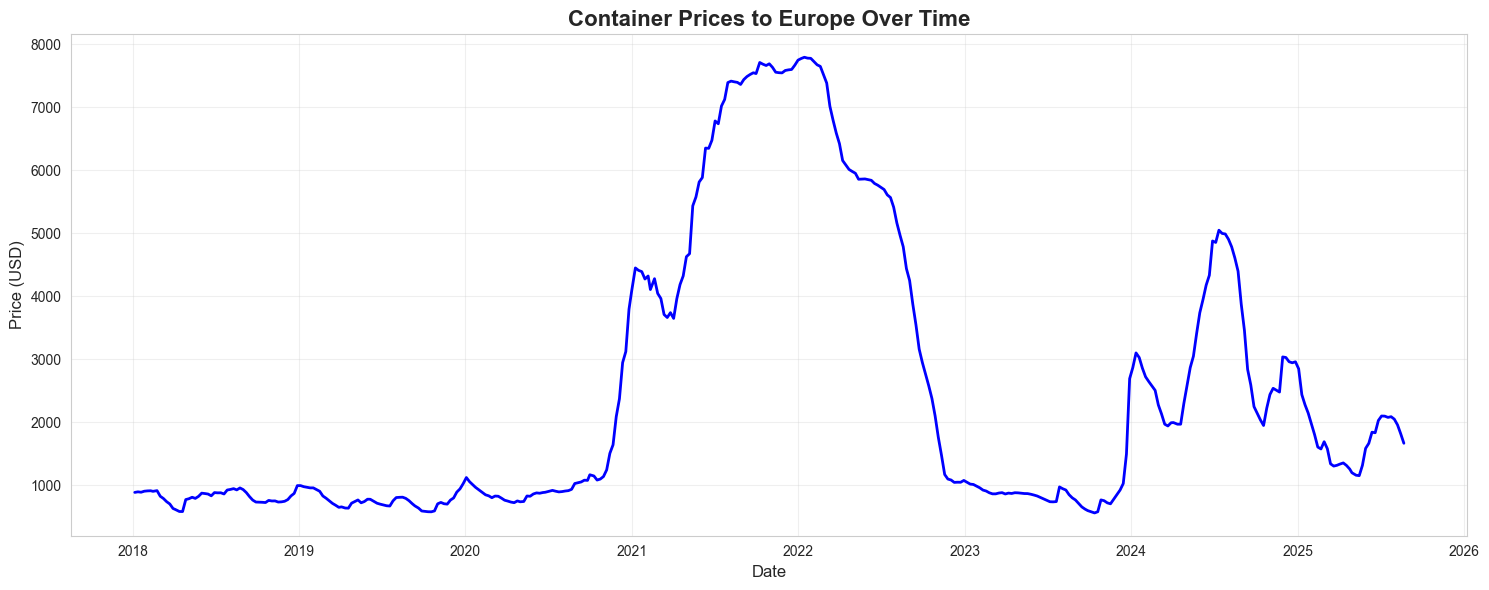

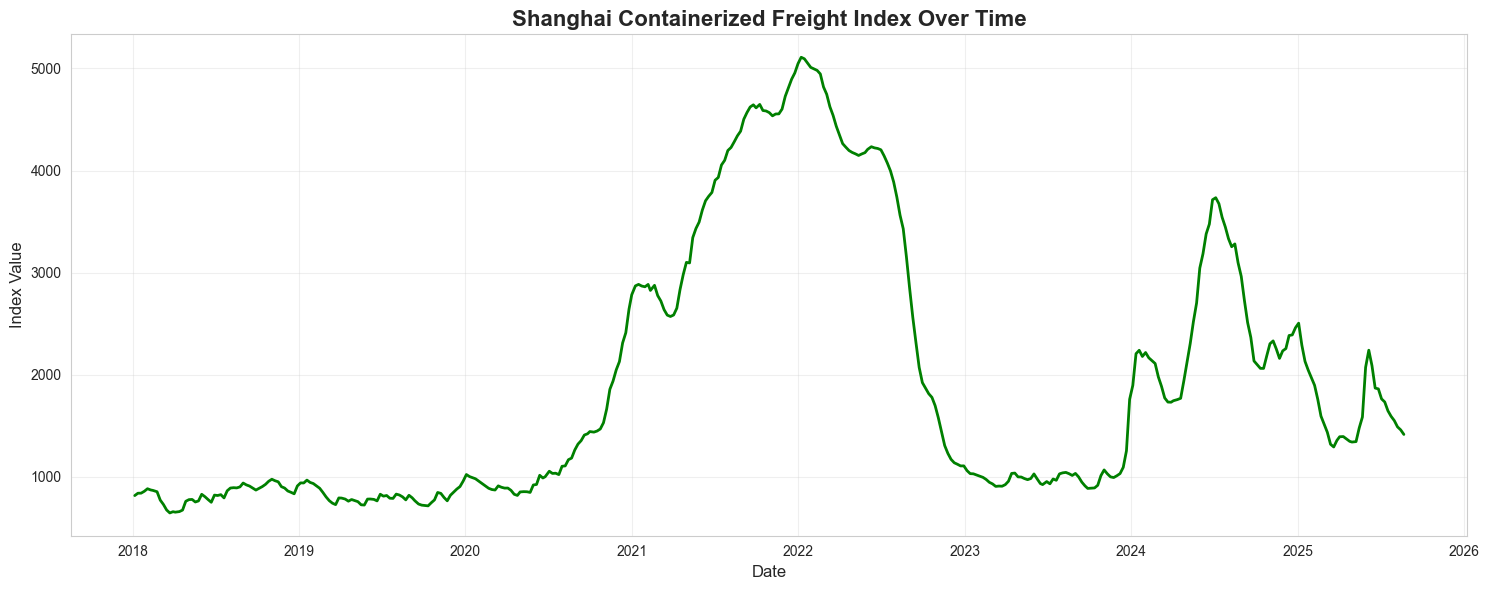

In [6]:
# Plot Europe Base Price over time
plt.figure(figsize=(15, 6))
plt.plot(df_freight.index, df_freight['Europe_Base_Price'], linewidth=2, color='blue')
plt.title('Container Prices to Europe Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also plot the SCFI Index
plt.figure(figsize=(15, 6))
plt.plot(df_freight.index, df_freight['SCFI_Index'], linewidth=2, color='green')
plt.title('Shanghai Containerized Freight Index Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 6: Distribution analysis

A histogram shows how frequently different price ranges occur. This helps us understand the typical price range and whether prices are evenly distributed or clustered.

### What is a distribution?

The distribution describes how values are spread out. For example, if most prices are between 100-200 USD with a few outliers at 500 USD, the distribution would show a concentration in the 100-200 range with a long tail extending to 500.

### What is a normal distribution?

A normal distribution (also called a bell curve) is a symmetric distribution where most values cluster around the mean, with fewer values as you move away from the center. Many statistical methods work best when data follows a normal distribution.

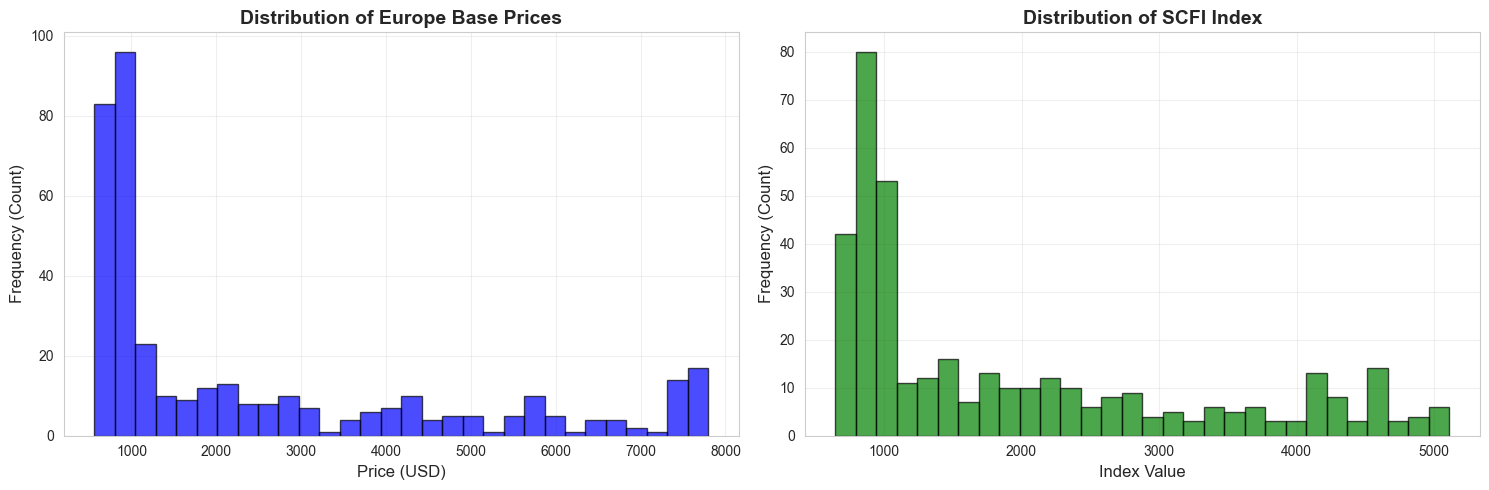

In [7]:
# Create histograms for both price variables
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Europe Base Price histogram
axes[0].hist(df_freight['Europe_Base_Price'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Europe Base Prices', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price (USD)', fontsize=12)
axes[0].set_ylabel('Frequency (Count)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# SCFI Index histogram
axes[1].hist(df_freight['SCFI_Index'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of SCFI Index', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index Value', fontsize=12)
axes[1].set_ylabel('Frequency (Count)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Time series decomposition

Time series decomposition breaks down our data into three components: trend, seasonality, and residuals (random noise).

### What is trend?

The trend is the long-term direction of the data. Is it generally increasing, decreasing, or staying flat over time?

### What is seasonality?

Seasonality refers to patterns that repeat at regular intervals. For example, retail sales often spike during the holiday season every year. In shipping, we might see seasonal patterns related to manufacturing cycles or weather.

### What are residuals?

Residuals are what is left after removing the trend and seasonality. They represent random fluctuations and unexpected events. Large residuals might indicate unusual occurrences like port strikes or economic shocks.

### Why decompose?

Understanding these components separately helps us build better models. Some models are great at capturing trends, others excel at seasonality, and some handle random fluctuations well.

Performing seasonal decomposition with yearly cycle (52 weeks)...


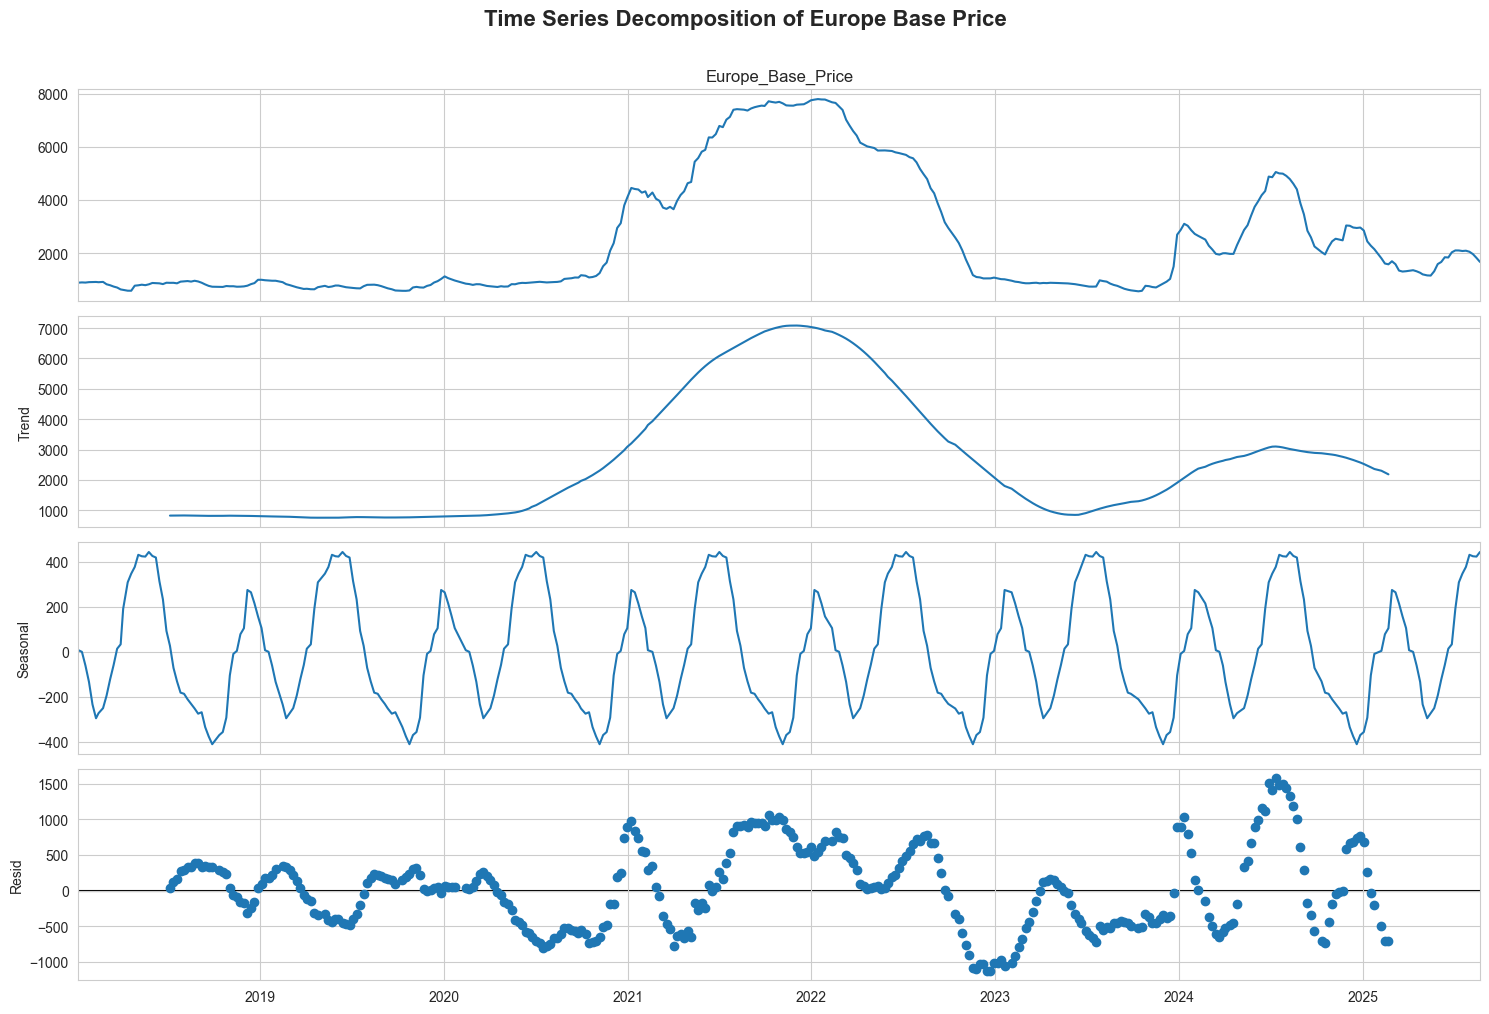


Interpretation:
- Observed: The actual price data
- Trend: The long-term movement in prices
- Seasonal: Repeating patterns within each year
- Residual: Random fluctuations and unexpected events


In [8]:
# Perform seasonal decomposition
# We need at least 2 complete cycles (2 years = 104 weeks) for reliable decomposition
if len(df_freight) >= 104:
    print("Performing seasonal decomposition with yearly cycle (52 weeks)...")
    
    # Decompose the Europe Base Price
    # model='additive' assumes components add together: Value = Trend + Seasonality + Residual
    # period=52 means we expect yearly patterns (52 weeks in a year)
    result = seasonal_decompose(df_freight['Europe_Base_Price'], model='additive', period=52)
    
    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(15, 10)
    plt.suptitle('Time Series Decomposition of Europe Base Price', y=1.01, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Observed: The actual price data")
    print("- Trend: The long-term movement in prices")
    print("- Seasonal: Repeating patterns within each year")
    print("- Residual: Random fluctuations and unexpected events")
    
else:
    print(f"Need at least 104 weeks (2 years) for reliable decomposition.")
    print(f"Current data has {len(df_freight)} weeks.")
    print("Skipping decomposition.")

## Step 7a: Seasonal Pattern Analysis and Price Impacts

Understanding seasonality is crucial for our predictions. We need to identify which months or quarters typically see higher or lower prices, and quantify the typical price changes during these periods.

### Why analyze seasonal impacts?

**Forecasting**: Knowing seasonal patterns helps predict next week's price more accurately

**Black Swan Context**: Seasonal baselines help us measure the additional impact of unexpected events

**Business Planning**: Companies can anticipate when shipping costs will rise or fall

### What to look for

**Recurring patterns**: Do certain months consistently have higher prices?

**Price amplitude**: How big are typical seasonal price swings?

**Timing**: When do seasonal effects start and end?

=== Seasonal Price Analysis ===

Average Europe Base Port Price by Month:
            mean          std  count
Jan  2741.516129  2308.893961     31
Feb  2381.500000  2182.694707     28
Mar  2044.888889  2005.510050     36
Apr  2182.166667  1987.103254     36
May  2384.656250  2076.159025     32
Jun  2584.970588  2249.800173     34
Jul  3012.400000  2509.785674     35
Aug  2715.228571  2338.669771     35
Sep  2533.937500  2444.056147     32
Oct  2365.086957  2580.249704     23
Nov  2116.645161  2244.234131     31
Dec  2683.968750  2385.044971     32

Overall average price: $2481.80

Monthly Price Impacts (vs. overall average):
Jan: $+259.71 (+10.5%) - typically higher
Feb: $-100.30 (-4.0%) - typically lower
Mar: $-436.91 (-17.6%) - typically lower
Apr: $-299.64 (-12.1%) - typically lower
May: $-97.15 (-3.9%) - typically lower
Jun: $+103.17 (+4.2%) - typically higher
Jul: $+530.60 (+21.4%) - typically higher
Aug: $+233.43 (+9.4%) - typically higher
Sep: $+52.13 (+2.1%) - typically higher

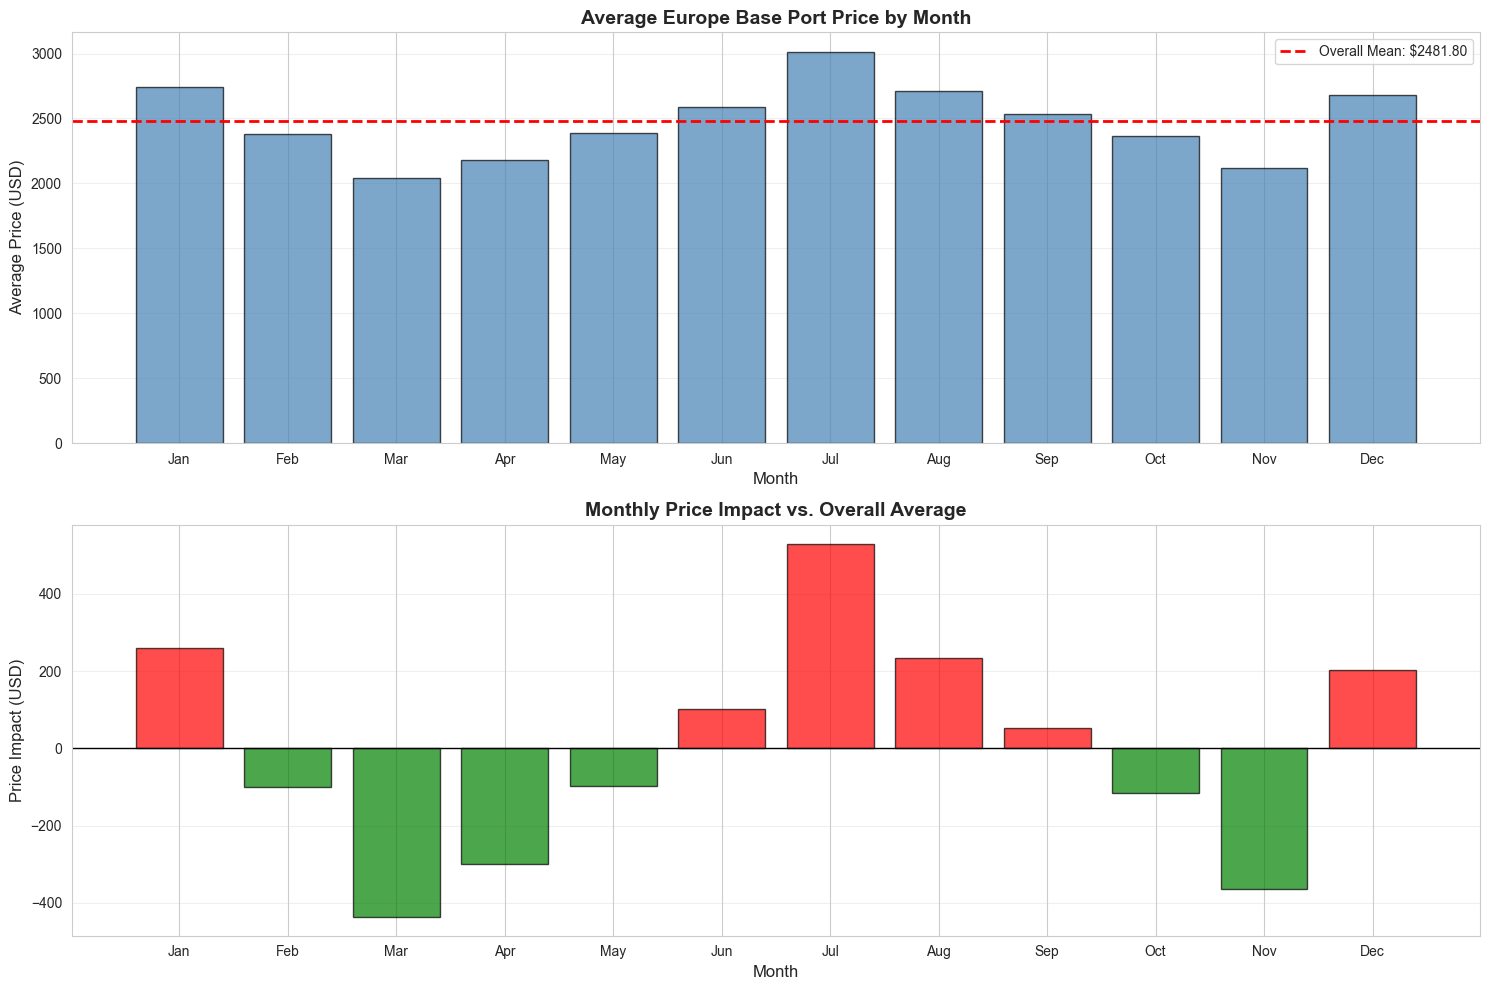


=== Quarterly Price Analysis ===

Quarterly Price Statistics:
                     mean          std  count  price_impact  impact_percent
Q1 (Jan-Mar)  2371.421053  2157.179475     95   -110.381545       -4.447636
Q2 (Apr-Jun)  2379.960784  2091.223366    102   -101.841813       -4.103542
Q3 (Jul-Sep)  2760.323529  2415.372637    102    278.520932       11.222526
Q4 (Oct-Dec)  2394.186047  2373.884677     86    -87.616551       -3.530359

Quarterly Price Impacts:
Q1 (Jan-Mar): $-110.38 (-4.4%) - typically lower
Q2 (Apr-Jun): $-101.84 (-4.1%) - typically lower
Q3 (Jul-Sep): $+278.52 (+11.2%) - typically higher
Q4 (Oct-Dec): $-87.62 (-3.5%) - typically lower

=== Key Seasonal Insights ===

Highest prices typically in: Jul
Lowest prices typically in: Mar
Typical seasonal price range: $967.51

These patterns help predict next week's price by accounting for
the time of year and typical seasonal fluctuations.


In [9]:
# Analyze seasonal patterns by month and quarter
print("=== Seasonal Price Analysis ===\n")

# Extract month and quarter from dates
df_freight['Month'] = df_freight.index.month
df_freight['Quarter'] = df_freight.index.quarter

# Calculate average price by month
monthly_avg = df_freight.groupby('Month')['Europe_Base_Price'].agg(['mean', 'std', 'count'])
monthly_avg.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Average Europe Base Port Price by Month:")
print(monthly_avg)

# Calculate price impact (difference from overall mean)
overall_mean = df_freight['Europe_Base_Price'].mean()
monthly_avg['price_impact'] = monthly_avg['mean'] - overall_mean
monthly_avg['impact_percent'] = (monthly_avg['price_impact'] / overall_mean) * 100

print(f"\nOverall average price: ${overall_mean:.2f}")
print("\nMonthly Price Impacts (vs. overall average):")
for month in monthly_avg.index:
    impact = monthly_avg.loc[month, 'price_impact']
    percent = monthly_avg.loc[month, 'impact_percent']
    direction = "higher" if impact > 0 else "lower"
    print(f"{month}: ${impact:+.2f} ({percent:+.1f}%) - typically {direction}")

# Visualize monthly patterns
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Monthly average prices
axes[0].bar(monthly_avg.index, monthly_avg['mean'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=overall_mean, color='red', linestyle='--', linewidth=2, label=f'Overall Mean: ${overall_mean:.2f}')
axes[0].set_title('Average Europe Base Port Price by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average Price (USD)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Monthly price impacts
colors = ['green' if x < 0 else 'red' for x in monthly_avg['price_impact']]
axes[1].bar(monthly_avg.index, monthly_avg['price_impact'], color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Monthly Price Impact vs. Overall Average', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Price Impact (USD)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Quarterly analysis
print("\n=== Quarterly Price Analysis ===\n")
quarterly_avg = df_freight.groupby('Quarter')['Europe_Base_Price'].agg(['mean', 'std', 'count'])
quarterly_avg.index = ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)']
quarterly_avg['price_impact'] = quarterly_avg['mean'] - overall_mean
quarterly_avg['impact_percent'] = (quarterly_avg['price_impact'] / overall_mean) * 100

print("Quarterly Price Statistics:")
print(quarterly_avg)

print("\nQuarterly Price Impacts:")
for quarter in quarterly_avg.index:
    impact = quarterly_avg.loc[quarter, 'price_impact']
    percent = quarterly_avg.loc[quarter, 'impact_percent']
    direction = "higher" if impact > 0 else "lower"
    print(f"{quarter}: ${impact:+.2f} ({percent:+.1f}%) - typically {direction}")

# Clean up temporary columns
df_freight = df_freight.drop(columns=['Month', 'Quarter'])

print("\n=== Key Seasonal Insights ===")
highest_month = monthly_avg['mean'].idxmax()
lowest_month = monthly_avg['mean'].idxmin()
seasonal_range = monthly_avg['mean'].max() - monthly_avg['mean'].min()

print(f"\nHighest prices typically in: {highest_month}")
print(f"Lowest prices typically in: {lowest_month}")
print(f"Typical seasonal price range: ${seasonal_range:.2f}")
print(f"\nThese patterns help predict next week's price by accounting for")
print(f"the time of year and typical seasonal fluctuations.")

## Step 7b: Black Swan Event Detection and Impact Analysis

Black swan events are unexpected, rare events that have major impacts. Examples include the Suez Canal blockage (2021), COVID-19 pandemic (2020), or geopolitical conflicts. While we cannot predict when these events will occur, we can identify them in historical data and measure their typical price impacts.

### What are we analyzing?

**Anomalies**: Price spikes or drops that deviate significantly from seasonal norms

**Impact magnitude**: How much did prices change during these events?

**Duration**: How long did the impact last?

**Recovery patterns**: How quickly did prices return to normal?

### Why this matters

**Risk assessment**: Understanding potential impact ranges helps with contingency planning

**Model robustness**: Knowing about outliers helps us build models that handle them better

**Business continuity**: Companies can prepare for possible future disruptions

### Detection method

We identify anomalies as weeks where the price deviates more than 2 standard deviations from the trend, after accounting for normal seasonality.

=== Black Swan Event Detection ===

Residual statistics:
  Mean: $30.90
  Std Dev: $570.11
  Anomaly threshold: ±$1140.22

=== Detected Anomalies (Potential Black Swan Events) ===
Found 9 anomalous weeks out of 333 total weeks
Anomaly rate: 2.7%

Top 10 largest anomalies:
1. 2024-07-12: $+1573.22 (spike) - Price: $5051.00
2. 2024-06-28: $+1502.32 (spike) - Price: $4880.00
3. 2024-07-26: $+1496.08 (spike) - Price: $4991.00
4. 2024-07-19: $+1479.19 (spike) - Price: $5000.00
5. 2024-08-02: $+1439.67 (spike) - Price: $4907.00
6. 2024-07-05: $+1414.16 (spike) - Price: $4857.00
7. 2024-08-09: $+1324.24 (spike) - Price: $4786.00
8. 2024-08-16: $+1188.12 (spike) - Price: $4610.00
9. 2024-06-14: $+1153.89 (spike) - Price: $4179.00


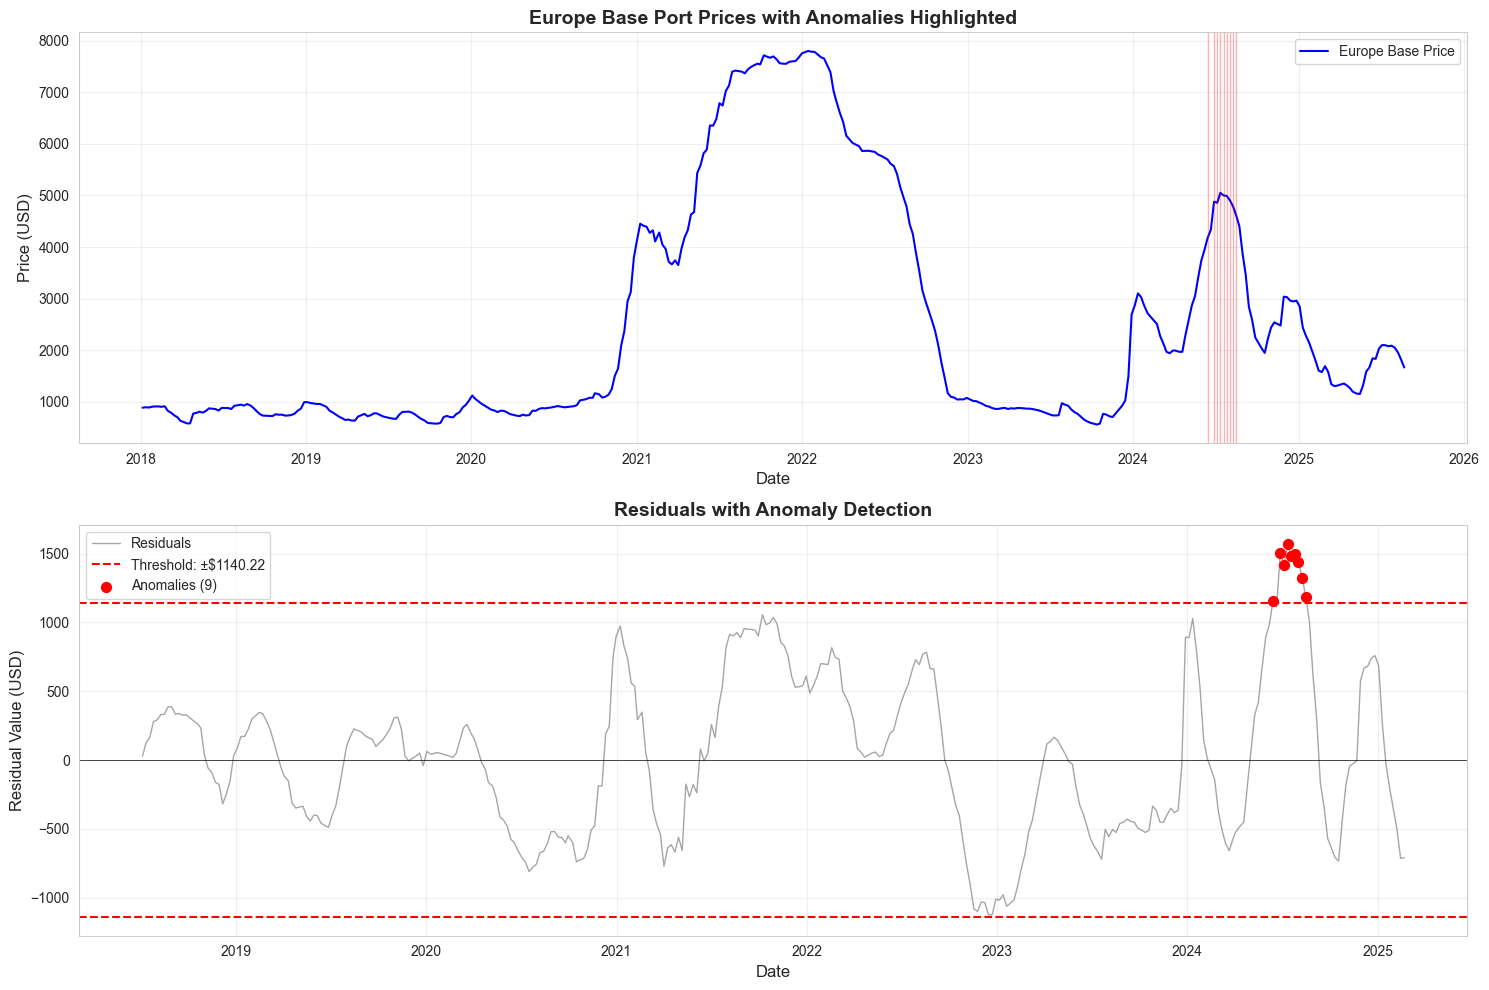


=== Anomaly Impact Statistics ===

Price spikes (positive anomalies): 9
  Average spike: +$1396.77
  Largest spike: +$1573.22

Price drops (negative anomalies): 0

=== Black Swan Impact Summary ===
Typical black swan price impact range: $1153.89 to +$1573.22
Average absolute impact: $1396.77

Note: We cannot predict WHEN black swan events will occur,
but these statistics show the typical price impact range when they do happen.


In [10]:
# Detect and analyze black swan events (anomalies)
print("=== Black Swan Event Detection ===\n")

# Use decomposition result if available
if len(df_freight) >= 104 and 'result' in locals():
    # Extract residuals (what's left after removing trend and seasonality)
    residuals = result.resid.dropna()
    
    # Calculate threshold for anomalies (2 standard deviations)
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    threshold = 2 * residual_std
    
    print(f"Residual statistics:")
    print(f"  Mean: ${residual_mean:.2f}")
    print(f"  Std Dev: ${residual_std:.2f}")
    print(f"  Anomaly threshold: ±${threshold:.2f}")
    
    # Identify anomalies
    anomalies = residuals[abs(residuals) > threshold]
    
    print(f"\n=== Detected Anomalies (Potential Black Swan Events) ===")
    print(f"Found {len(anomalies)} anomalous weeks out of {len(residuals)} total weeks")
    print(f"Anomaly rate: {len(anomalies) / len(residuals) * 100:.1f}%\n")
    
    if len(anomalies) > 0:
        # Show top anomalies
        anomalies_sorted = anomalies.abs().sort_values(ascending=False)
        
        print("Top 10 largest anomalies:")
        for i, (date, value) in enumerate(anomalies_sorted.head(10).items(), 1):
            actual_residual = residuals[date]
            actual_price = df_freight.loc[date, 'Europe_Base_Price']
            direction = "spike" if actual_residual > 0 else "drop"
            print(f"{i}. {date.strftime('%Y-%m-%d')}: ${actual_residual:+.2f} ({direction}) - Price: ${actual_price:.2f}")
        
        # Visualize anomalies
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Prices with anomalies highlighted
        axes[0].plot(df_freight.index, df_freight['Europe_Base_Price'], 
                    label='Europe Base Price', color='blue', linewidth=1.5)
        
        # Highlight anomaly periods
        for date in anomalies.index:
            axes[0].axvline(x=date, color='red', alpha=0.3, linewidth=1)
        
        axes[0].set_title('Europe Base Port Prices with Anomalies Highlighted', 
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date', fontsize=12)
        axes[0].set_ylabel('Price (USD)', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Residuals with threshold
        axes[1].plot(residuals.index, residuals, label='Residuals', 
                    color='gray', linewidth=1, alpha=0.7)
        axes[1].axhline(y=threshold, color='red', linestyle='--', 
                       label=f'Threshold: ±${threshold:.2f}')
        axes[1].axhline(y=-threshold, color='red', linestyle='--')
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        # Highlight anomalies
        axes[1].scatter(anomalies.index, anomalies, color='red', s=50, 
                       label=f'Anomalies ({len(anomalies)})', zorder=5)
        
        axes[1].set_title('Residuals with Anomaly Detection', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date', fontsize=12)
        axes[1].set_ylabel('Residual Value (USD)', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Analyze impact statistics
        positive_anomalies = anomalies[anomalies > 0]
        negative_anomalies = anomalies[anomalies < 0]
        
        print(f"\n=== Anomaly Impact Statistics ===")
        print(f"\nPrice spikes (positive anomalies): {len(positive_anomalies)}")
        if len(positive_anomalies) > 0:
            print(f"  Average spike: +${positive_anomalies.mean():.2f}")
            print(f"  Largest spike: +${positive_anomalies.max():.2f}")
        
        print(f"\nPrice drops (negative anomalies): {len(negative_anomalies)}")
        if len(negative_anomalies) > 0:
            print(f"  Average drop: ${negative_anomalies.mean():.2f}")
            print(f"  Largest drop: ${negative_anomalies.min():.2f}")
        
        print(f"\n=== Black Swan Impact Summary ===")
        print(f"Typical black swan price impact range: ${anomalies.min():.2f} to +${anomalies.max():.2f}")
        print(f"Average absolute impact: ${anomalies.abs().mean():.2f}")
        print(f"\nNote: We cannot predict WHEN black swan events will occur,")
        print(f"but these statistics show the typical price impact range when they do happen.")
        
    else:
        print("No significant anomalies detected in the data.")
        
else:
    print("Decomposition not available (need at least 104 weeks of data).")
    print("Using simple volatility analysis instead...\n")
    
    # Simple volatility-based anomaly detection
    price_mean = df_freight['Europe_Base_Price'].mean()
    price_std = df_freight['Europe_Base_Price'].std()
    threshold = 2 * price_std
    
    upper_bound = price_mean + threshold
    lower_bound = price_mean - threshold
    
    anomalies = df_freight[(df_freight['Europe_Base_Price'] > upper_bound) | 
                          (df_freight['Europe_Base_Price'] < lower_bound)]
    
    print(f"Found {len(anomalies)} weeks with extreme prices")
    print(f"Normal range: ${lower_bound:.2f} - ${upper_bound:.2f}")
    print(f"Mean price: ${price_mean:.2f}")

## Step 8: Stationarity test

Stationarity is a property where the statistical properties of a time series (like mean and variance) do not change over time.

### Why does stationarity matter?

Many time series models assume the data is stationary. If it is not stationary, the model might make poor predictions. Non-stationary data often has trends or changing variance that need to be addressed.

### What is the Augmented Dickey-Fuller (ADF) test?

The ADF test is a statistical test that checks whether a time series is stationary. It gives us a test statistic and a p-value.

### How to interpret the results

p-value: This is the probability that our data is non-stationary. If p-value is less than 0.05 (5%), we can be confident the data is stationary. If p-value is greater than 0.05, the data is likely non-stationary.

Test statistic: We compare this to critical values. If the test statistic is more negative than the critical value, the data is likely stationary.

### What if data is non-stationary?

We can make it stationary through differencing (subtracting consecutive values) or detrending (removing the trend component).


=== Stationarity Analysis for Europe Base Price ===


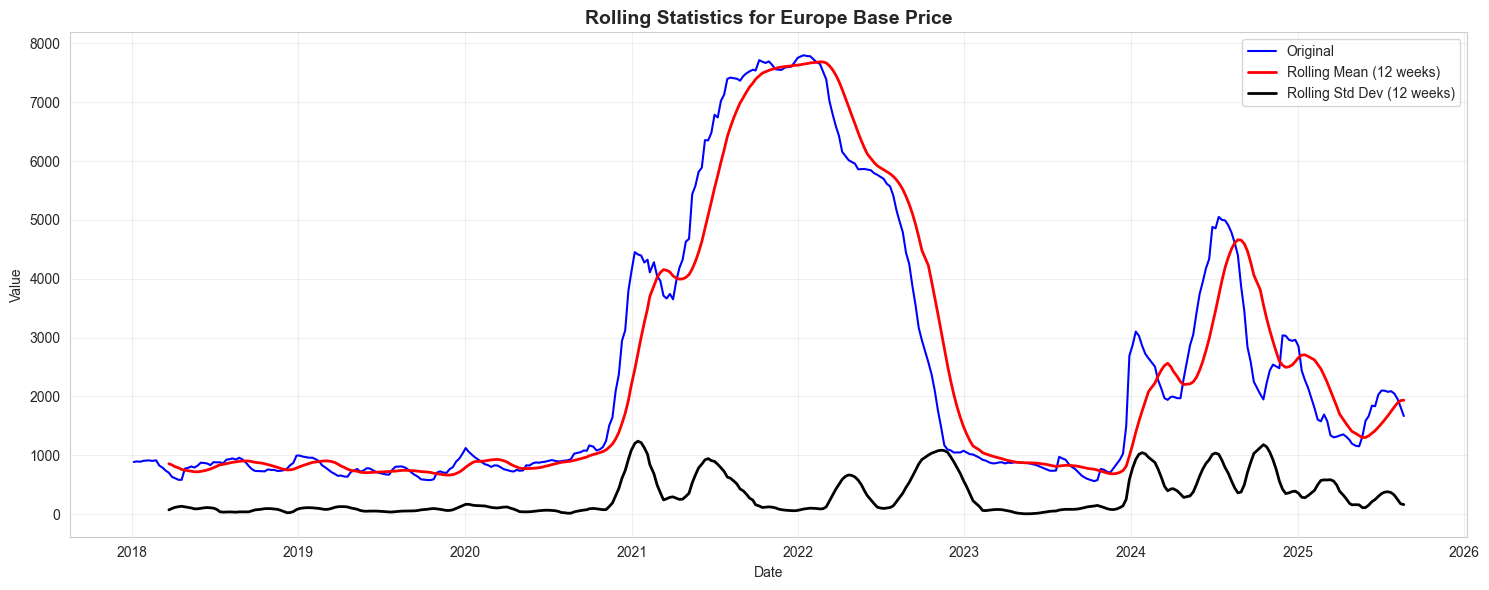


Augmented Dickey-Fuller Test Results:
Test Statistic             -2.088145
p-value                     0.249308
Lags Used                  17.000000
Number of Observations    367.000000
dtype: float64

Critical Values:
  1%: -3.448
  5%: -2.869
  10%: -2.571

Interpretation:
  p-value = 0.2493 (greater than 0.05)
  Result: The series is likely NON-STATIONARY.
  This means it has trends or changing variance that may need addressing.


In [11]:
def check_stationarity(timeseries, column_name):
    print(f"\n=== Stationarity Analysis for {column_name} ===")
    
    # Calculate rolling statistics
    # Rolling mean and std over 12 weeks (about 3 months)
    window = 12
    rolling_mean = timeseries.rolling(window).mean()
    rolling_std = timeseries.rolling(window).std()

    # Plot the data with rolling statistics
    plt.figure(figsize=(15, 6))
    plt.plot(timeseries, color='blue', label='Original', linewidth=1.5)
    plt.plot(rolling_mean, color='red', label=f'Rolling Mean ({window} weeks)', linewidth=2)
    plt.plot(rolling_std, color='black', label=f'Rolling Std Dev ({window} weeks)', linewidth=2)
    plt.legend(loc='best')
    plt.title(f'Rolling Statistics for {column_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print('\nAugmented Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations'])
    
    print(dfoutput)
    
    print('\nCritical Values:')
    for key, value in dftest[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('\nInterpretation:')
    if dfoutput['p-value'] <= 0.05:
        print(f"  p-value = {dfoutput['p-value']:.4f} (less than 0.05)")
        print("  Result: The series is likely STATIONARY.")
        print("  This means the statistical properties are stable over time.")
    else:
        print(f"  p-value = {dfoutput['p-value']:.4f} (greater than 0.05)")
        print("  Result: The series is likely NON-STATIONARY.")
        print("  This means it has trends or changing variance that may need addressing.")

# Check stationarity for Europe Base Price
check_stationarity(df_freight['Europe_Base_Price'], 'Europe Base Price')

## Step 9: Correlation analysis

Correlation measures how strongly two variables are related to each other.

### What is correlation?

Correlation values range from -1 to +1. A value of +1 means perfect positive correlation (when one goes up, the other goes up). A value of -1 means perfect negative correlation (when one goes up, the other goes down). A value of 0 means no correlation.

### Why check correlations?

Understanding correlations helps us identify which variables might be useful for predicting our target variable (Europe Base Price). Strong correlations suggest that a variable contains information relevant to our prediction task.

=== Correlation Matrix ===
                   SCFI_Index  Europe_Base_Price
SCFI_Index           1.000000           0.987179
Europe_Base_Price    0.987179           1.000000


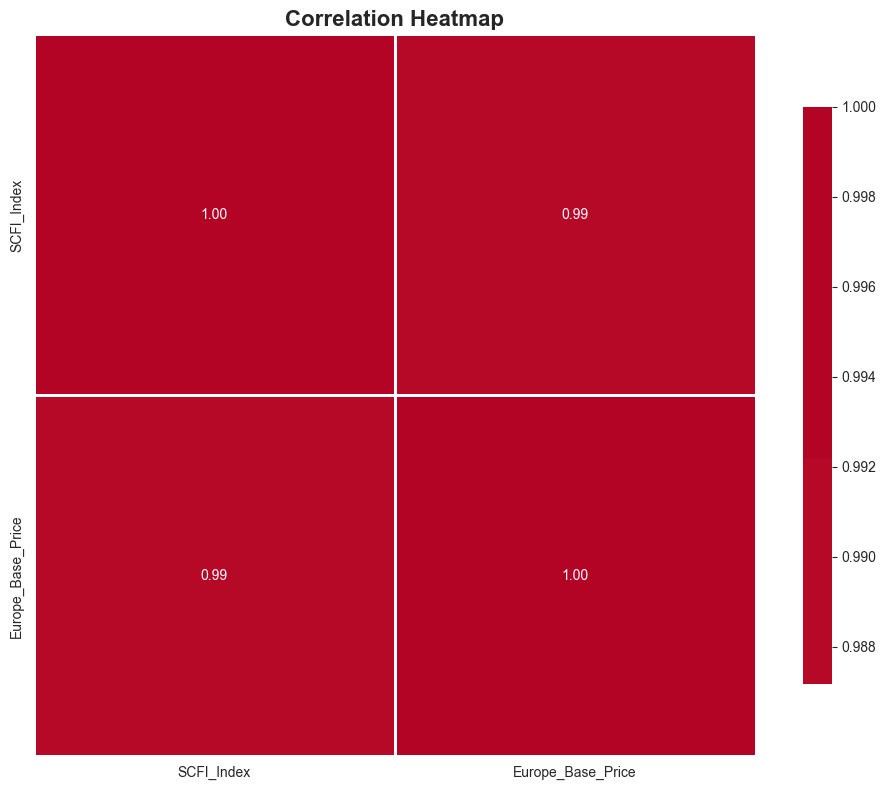


Interpretation Guide:
- Values close to +1: Strong positive correlation
- Values close to -1: Strong negative correlation
- Values close to 0: Little to no correlation

Correlation with Europe Base Price:
Europe_Base_Price    1.000000
SCFI_Index           0.987179
Name: Europe_Base_Price, dtype: float64


In [17]:
# Calculate correlation matrix
correlation_matrix = df_freight.corr()

print("=== Correlation Matrix ===")
print(correlation_matrix)

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation Guide:")
print("- Values close to +1: Strong positive correlation")
print("- Values close to -1: Strong negative correlation")
print("- Values close to 0: Little to no correlation")
print("\nCorrelation with Europe Base Price:")
print(correlation_matrix['Europe_Base_Price'].sort_values(ascending=False))

## Step 10: Analyze oil price relationship (if available)

If we have oil price data, we can examine how it relates to container prices.

=== Oil Price Analysis ===
Oil data: 2787 days

Oil price statistics:
count    2787.000000
mean      103.579650
std        24.649472
min        50.000000
25%        80.566657
50%       120.000000
75%       120.000000
max       120.000000
Name: Oil_Price, dtype: float64


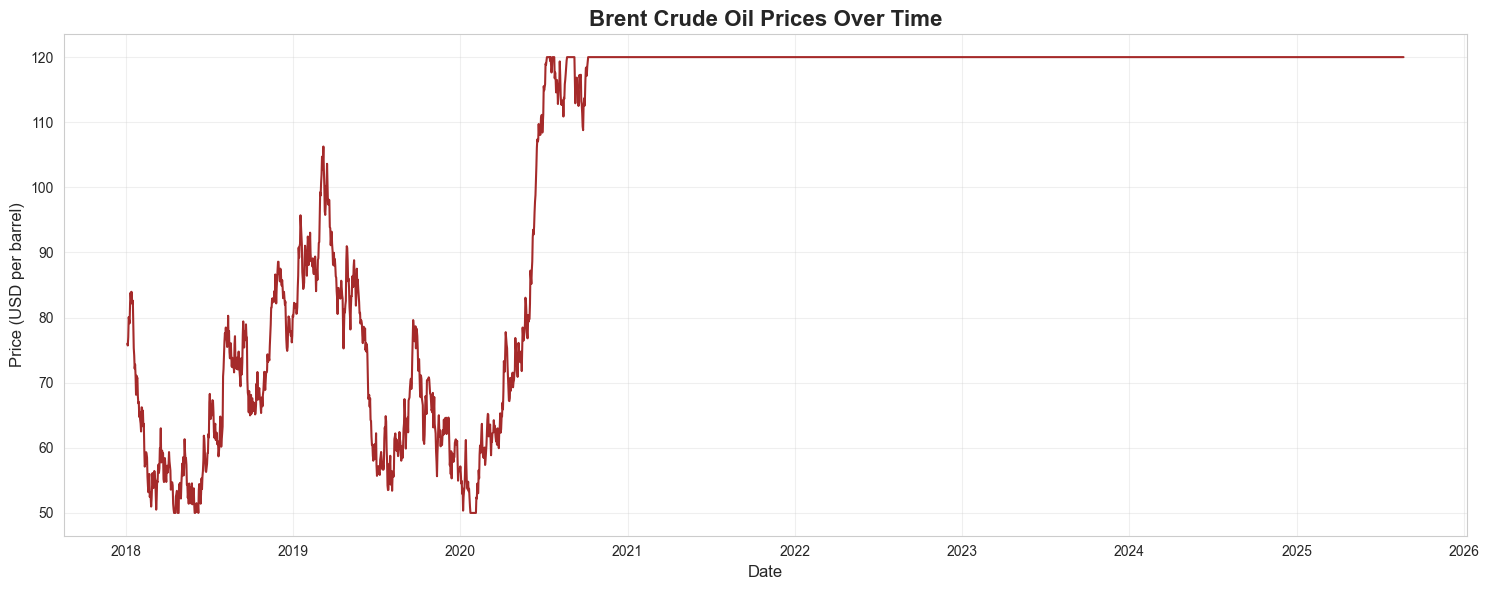

In [18]:
if has_oil:
    print("=== Oil Price Analysis ===")
    print(f"Oil data: {len(df_oil)} days")
    print(f"\nOil price statistics:")
    print(df_oil['Oil_Price'].describe())
    
    # Plot oil prices over time
    plt.figure(figsize=(15, 6))
    plt.plot(df_oil.index, df_oil['Oil_Price'], linewidth=1.5, color='brown')
    plt.title('Brent Crude Oil Prices Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD per barrel)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No oil price data available for analysis.")

## Step 12: Analyze GDELT geopolitical disruption data (if available)

If we have GDELT disruption data, we can examine how geopolitical events relate to container prices.

### What is the disruption index?

The disruption index is a composite metric combining:
- **Severe events** (weight 3.0): Events with strong negative impact (GoldsteinScale < -3)
- **Conflict events** (weight 2.0): Military/violent events (QuadClass 3,4)
- **Media mentions** (weight 1.0): Volume of news coverage

Higher values indicate more severe geopolitical disruptions in shipping-critical regions.

### Geographic focus

Our GDELT data focuses on countries critical to global shipping routes:
- **Choke points**: Egypt (Suez Canal), Yemen (Bab-el-Mandeb Strait)
- **Major ports**: China, Singapore, Netherlands, Germany
- **Geopolitical risks**: Iran, Israel, Taiwan, Ukraine, Russia

### What to look for

- **Correlation with prices**: Do disruptions precede price increases?
- **Major events**: Can we identify historical black swan events (COVID-19, Suez blockage, wars)?
- **Sentiment patterns**: How does media tone relate to price movements?

GDELT GEOPOLITICAL DISRUPTION ANALYSIS

GDELT data: 412 weekly records
Date range: 2017-12-29 to 2026-01-02

=== Disruption Metrics Statistics ===
       disruption_index        tone  conflict_count  severe_event_count  \
count        412.000000  412.000000      412.000000          412.000000   
mean         237.884997   -4.075025    70166.546117        31340.519417   
std           98.949670    0.406765    26345.110055        15306.719116   
min            1.703070   -5.666863      473.000000          246.000000   
25%          167.636150   -4.326780    52542.250000        19154.250000   
50%          232.831585   -4.005616    69879.000000        29295.500000   
75%          288.239170   -3.788334    83772.250000        39287.500000   
max          687.690040   -3.169543   192015.000000       106428.000000   

       media_mentions  
count      412.000000  
mean    353034.669903  
std     126490.848220  
min       1907.000000  
25%     263263.000000  
50%     351412.000000  
75%     4

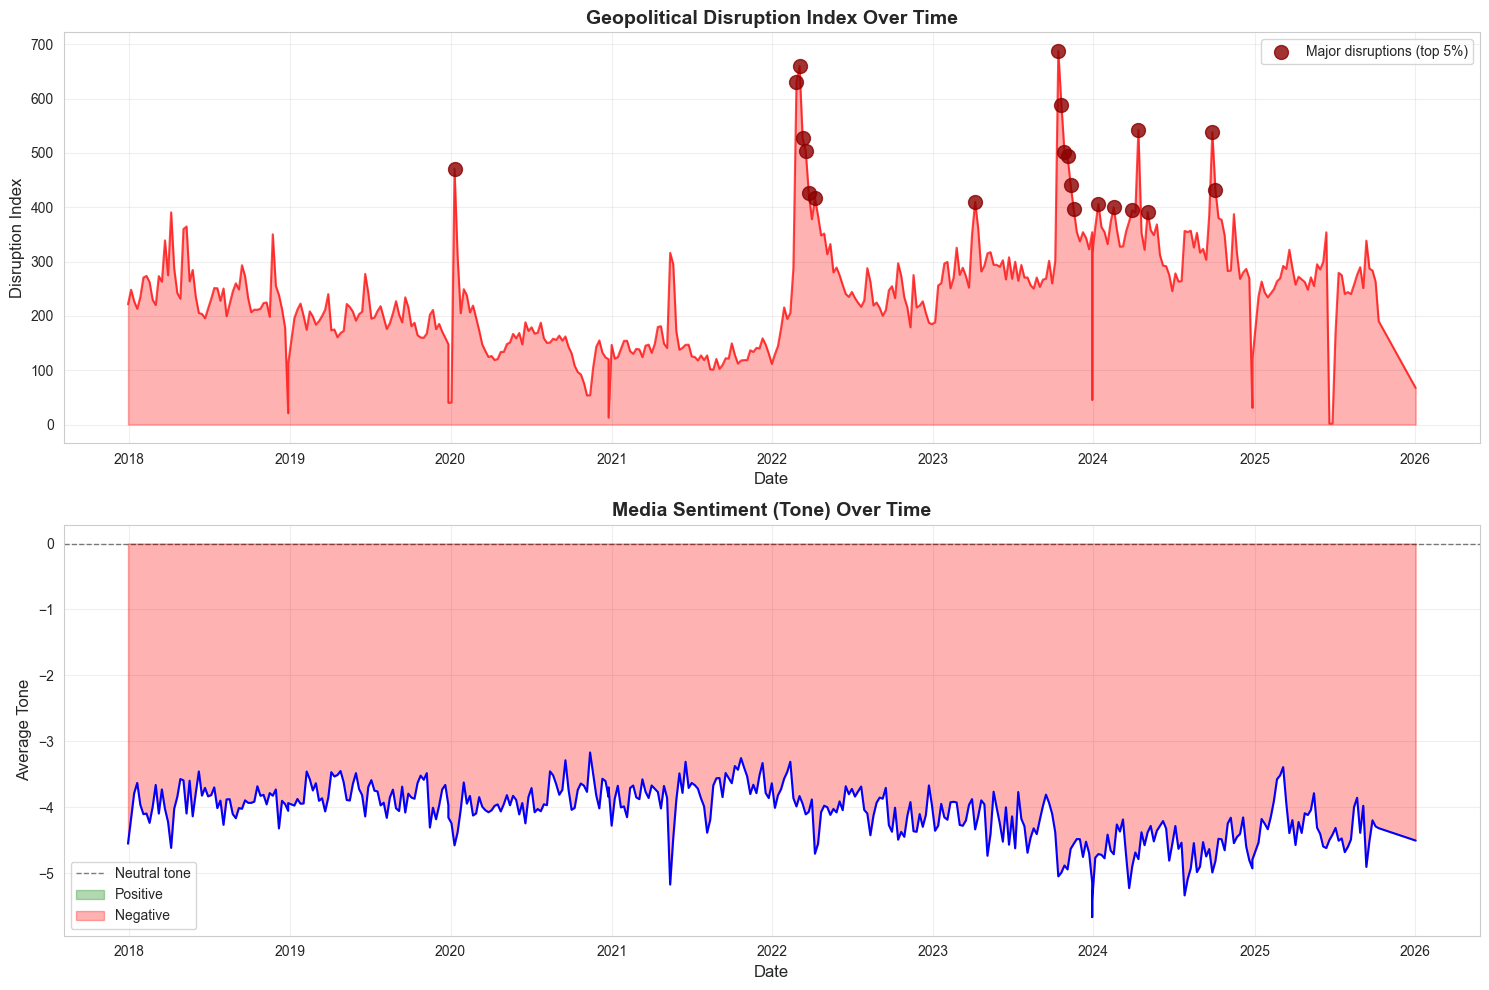

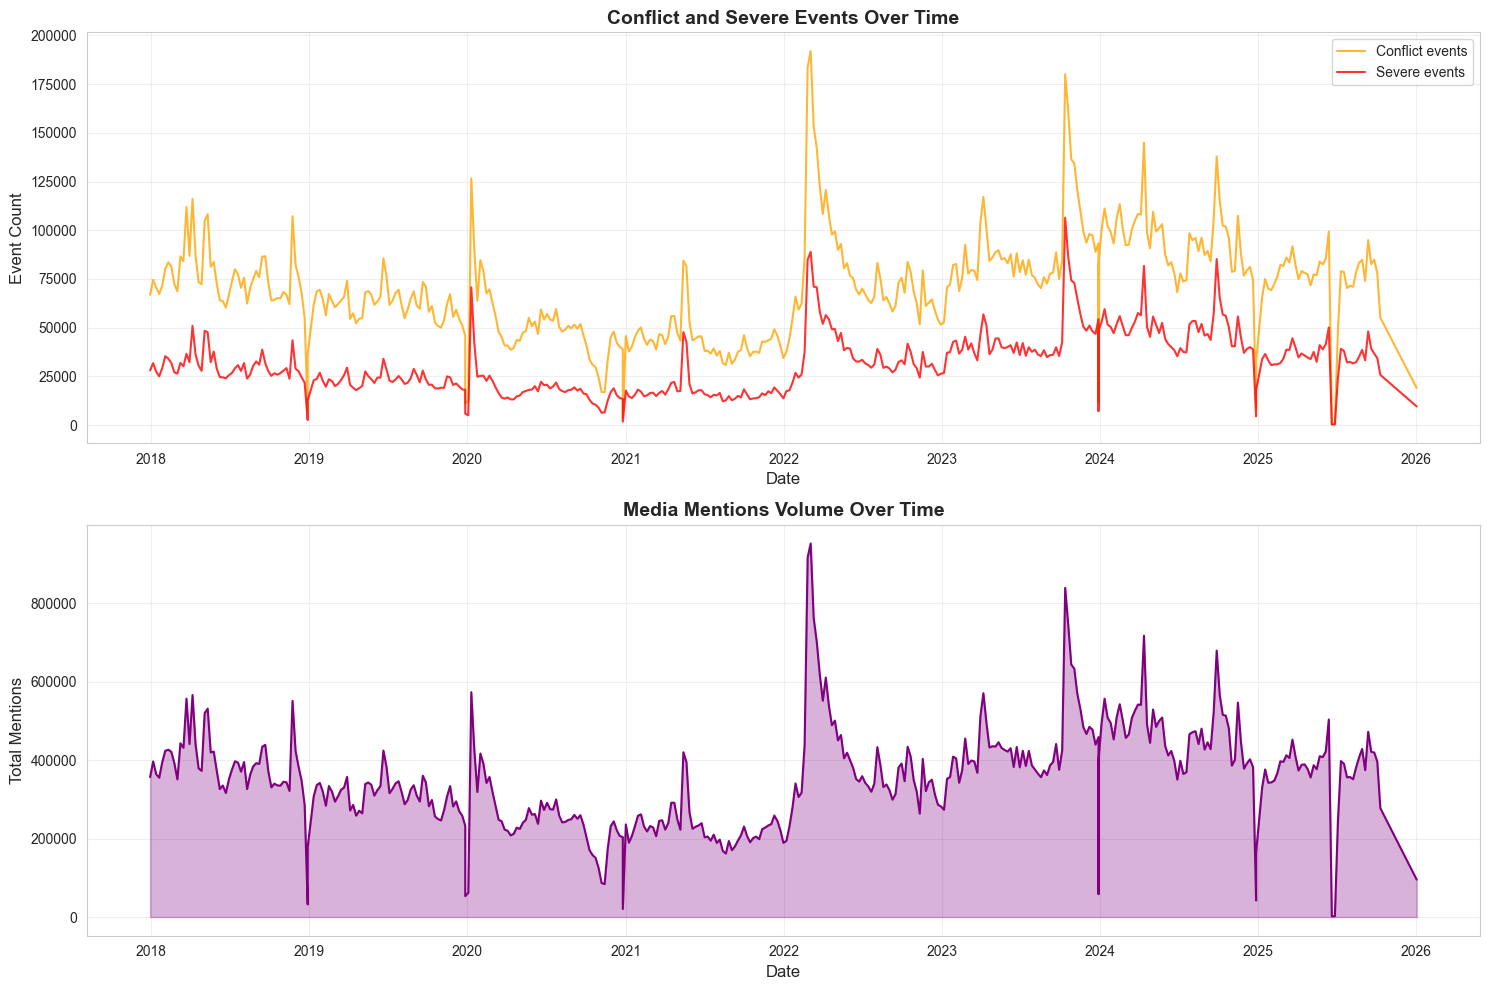


TOP 15 DISRUPTION WEEKS (Historical Black Swan Events)

Date         Disruption   Conflicts  Severe     Tone     Media       
----------------------------------------------------------------------
2023-10-13   687.69       180010     106428     -5.05    838604      
2022-03-04   660.20       192015     88886      -3.83    951669      
2022-02-25   631.14       183730     84838      -3.99    916111      
2023-10-20   589.21       161233     86432      -4.99    744482      
2024-04-12   542.26       145007     81692      -4.79    716773      
2024-09-27   538.24       137876     85232      -4.99    678786      
2022-03-11   526.92       153096     71038      -3.95    761458      
2022-03-18   503.89       142348     70725      -4.11    701886      
2023-10-27   502.11       136449     74259      -4.88    643314      
2023-11-03   494.06       134360     73004      -4.94    632999      
2020-01-10   471.05       126586     70717      -4.58    572742      
2023-11-10   441.39       120567

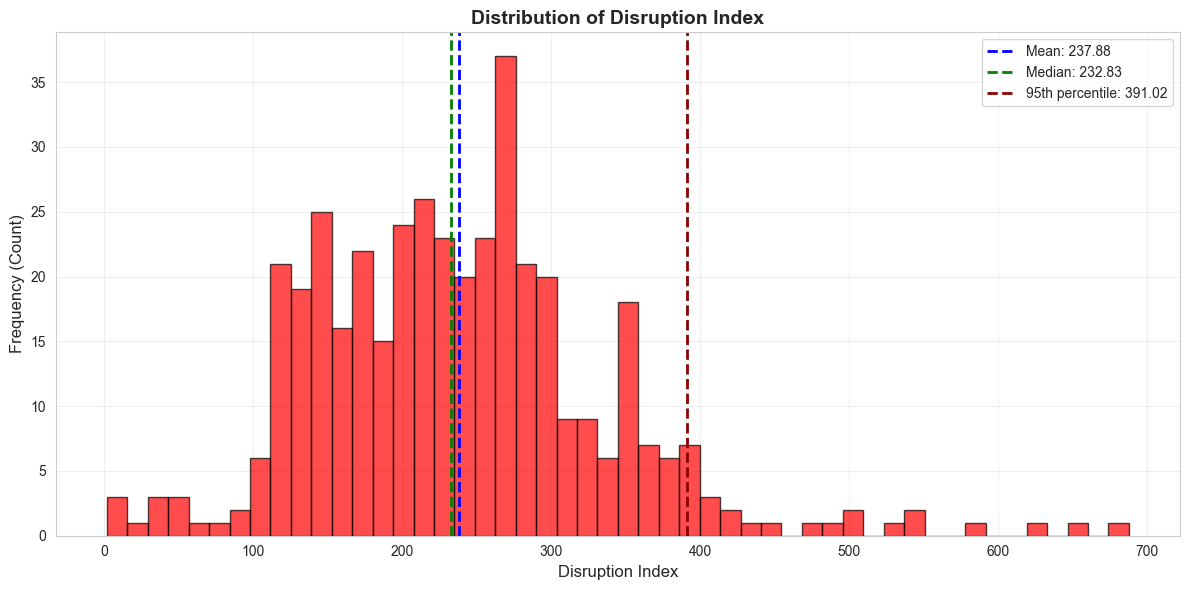


=== Disruption Index Statistics ===
Mean: 237.885
Median: 232.832
Std Dev: 98.950
95th percentile: 391.021

Weeks above 95th percentile: 21 (5.1%)


In [14]:
if has_news:
    print("=" * 70)
    print("GDELT GEOPOLITICAL DISRUPTION ANALYSIS")
    print("=" * 70)
    
    print(f"\nGDELT data: {len(df_news)} weekly records")
    print(f"Date range: {df_news.index.min().strftime('%Y-%m-%d')} to {df_news.index.max().strftime('%Y-%m-%d')}")
    
    print("\n=== Disruption Metrics Statistics ===")
    print(df_news.describe())
    
    # Disruption index over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Disruption index
    axes[0].plot(df_news.index, df_news['disruption_index'], linewidth=1.5, color='red', alpha=0.7)
    axes[0].fill_between(df_news.index, 0, df_news['disruption_index'], alpha=0.3, color='red')
    axes[0].set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Disruption Index', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Highlight major disruption weeks (top 5%)
    threshold_95 = df_news['disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['disruption_index'] > threshold_95]
    axes[0].scatter(major_disruptions.index, major_disruptions['disruption_index'], 
                   color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    axes[0].legend()
    
    # Plot 2: Media sentiment (tone)
    axes[1].plot(df_news.index, df_news['tone'], linewidth=1.5, color='blue')
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Neutral tone')
    axes[1].fill_between(df_news.index, 0, df_news['tone'], 
                        where=df_news['tone'] > 0, alpha=0.3, color='green', label='Positive')
    axes[1].fill_between(df_news.index, 0, df_news['tone'], 
                        where=df_news['tone'] <= 0, alpha=0.3, color='red', label='Negative')
    axes[1].set_title('Media Sentiment (Tone) Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Average Tone', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Event counts over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Conflict and severe events
    axes[0].plot(df_news.index, df_news['conflict_count'], linewidth=1.5, color='orange', 
                label='Conflict events', alpha=0.8)
    axes[0].plot(df_news.index, df_news['severe_event_count'], linewidth=1.5, color='red', 
                label='Severe events', alpha=0.8)
    axes[0].set_title('Conflict and Severe Events Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Event Count', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Media mentions
    axes[1].plot(df_news.index, df_news['media_mentions'], linewidth=1.5, color='purple')
    axes[1].fill_between(df_news.index, 0, df_news['media_mentions'], alpha=0.3, color='purple')
    axes[1].set_title('Media Mentions Volume Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Total Mentions', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify and display top disruption weeks
    print("\n" + "=" * 70)
    print("TOP 15 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("=" * 70)
    top_disruptions = df_news.nlargest(15, 'disruption_index')[
        ['disruption_index', 'conflict_count', 'severe_event_count', 'tone', 'media_mentions']
    ]
    
    print("\n{:<12} {:<12} {:<10} {:<10} {:<8} {:<12}".format(
        'Date', 'Disruption', 'Conflicts', 'Severe', 'Tone', 'Media'))
    print("-" * 70)
    for date, row in top_disruptions.iterrows():
        print("{:<12} {:<12.2f} {:<10.0f} {:<10.0f} {:<8.2f} {:<12.0f}".format(
            date.strftime('%Y-%m-%d'),
            row['disruption_index'],
            row['conflict_count'],
            row['severe_event_count'],
            row['tone'],
            row['media_mentions']
        ))
    
    # Historical context for major events
    print("\n" + "=" * 70)
    print("HISTORICAL CONTEXT")
    print("=" * 70)
    print("\nExpected major events in this timeframe (2018-2025):")
    print("  - COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  - Suez Canal blockage (March 2021): Ever Given incident")
    print("  - Russia-Ukraine war (Feb 2022-present): Grain exports, fuel prices")
    print("  - Israel-Hamas conflict (Oct 2023-present): Red Sea shipping disruptions")
    print("\nCheck if these events appear in the top disruption weeks above.")
    
    # Distribution of disruption index
    plt.figure(figsize=(12, 6))
    plt.hist(df_news['disruption_index'], bins=50, color='red', alpha=0.7, edgecolor='black')
    plt.axvline(df_news['disruption_index'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f'Mean: {df_news["disruption_index"].mean():.2f}')
    plt.axvline(df_news['disruption_index'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df_news["disruption_index"].median():.2f}')
    plt.axvline(threshold_95, color='darkred', linestyle='--', 
                linewidth=2, label=f'95th percentile: {threshold_95:.2f}')
    plt.title('Distribution of Disruption Index', fontsize=14, fontweight='bold')
    plt.xlabel('Disruption Index', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n=== Disruption Index Statistics ===")
    print(f"Mean: {df_news['disruption_index'].mean():.3f}")
    print(f"Median: {df_news['disruption_index'].median():.3f}")
    print(f"Std Dev: {df_news['disruption_index'].std():.3f}")
    print(f"95th percentile: {threshold_95:.3f}")
    print(f"\nWeeks above 95th percentile: {len(major_disruptions)} ({len(major_disruptions)/len(df_news)*100:.1f}%)")
    
else:
    print("No GDELT disruption data available for analysis.")

## Step 13: Correlation between disruptions and container prices

Let's examine how geopolitical disruptions correlate with container price changes. This helps us understand whether disruption indicators are useful predictive features.

DISRUPTION-PRICE CORRELATION ANALYSIS

Combined dataset: 371 weeks with both freight and disruption data
Date range: 2018-01-05 to 2025-08-22

=== Correlation Matrix ===
                    Europe_Base_Price  SCFI_Index  disruption_index      tone  \
Europe_Base_Price            1.000000    0.986903         -0.080398  0.106022   
SCFI_Index                   0.986903    1.000000         -0.036084  0.064342   
disruption_index            -0.080398   -0.036084          1.000000 -0.534371   
tone                         0.106022    0.064342         -0.534371  1.000000   
conflict_count              -0.111031   -0.072404          0.992495 -0.470923   
severe_event_count          -0.043196    0.006988          0.989503 -0.599088   
media_mentions              -0.095190   -0.057865          0.987474 -0.456253   

                    conflict_count  severe_event_count  media_mentions  
Europe_Base_Price        -0.111031           -0.043196       -0.095190  
SCFI_Index               -0.072404 

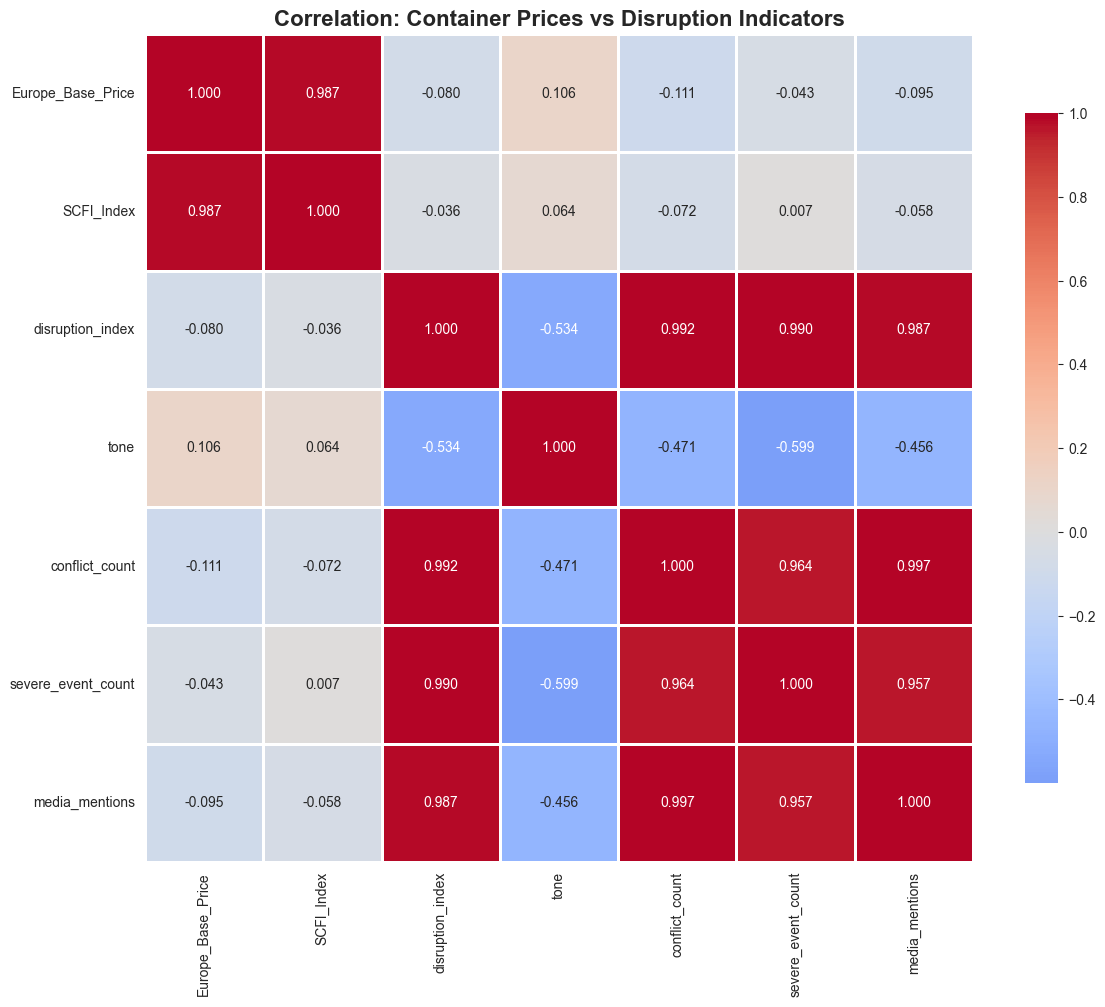


=== Correlation with Europe Base Price ===
tone                  0.106022
severe_event_count   -0.043196
disruption_index     -0.080398
media_mentions       -0.095190
conflict_count       -0.111031
Name: Europe_Base_Price, dtype: float64

=== Interpretation ===
  tone: WEAK positive correlation (0.106)
  severe_event_count: NEGLIGIBLE negative correlation (-0.043)
  disruption_index: NEGLIGIBLE negative correlation (-0.080)
  media_mentions: NEGLIGIBLE negative correlation (-0.095)
  conflict_count: WEAK negative correlation (-0.111)


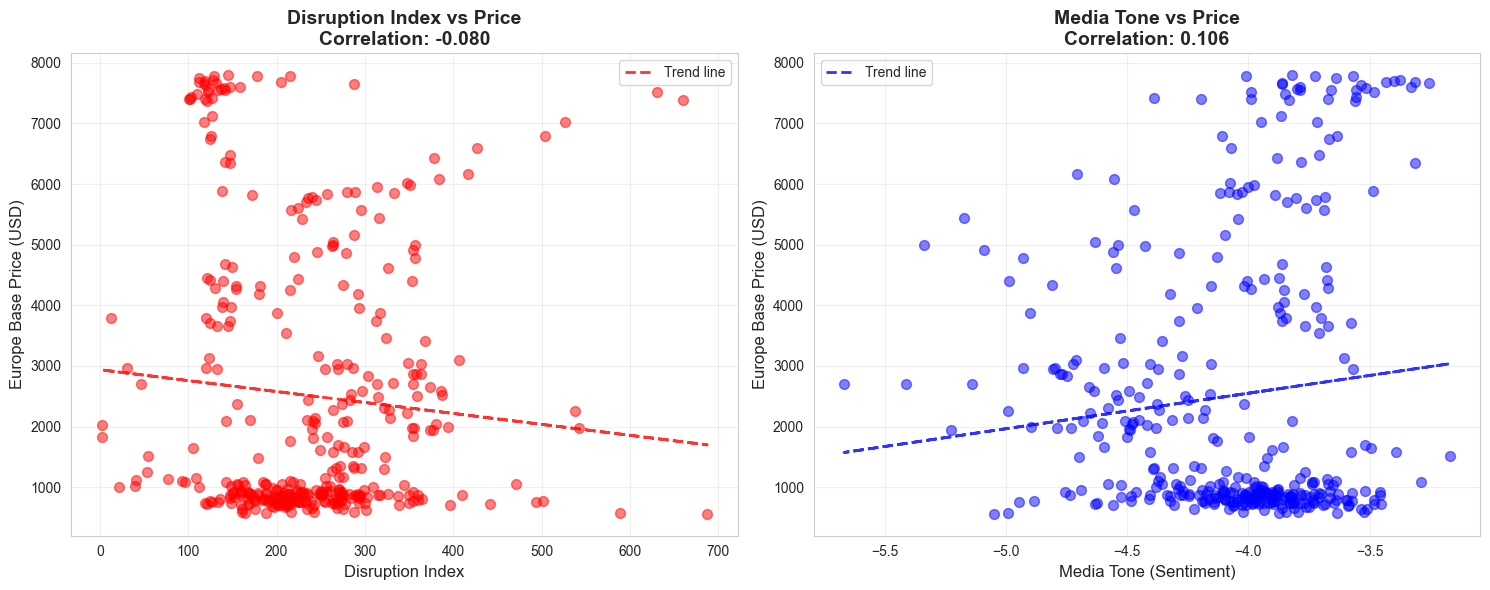


LAGGED CORRELATION ANALYSIS (Do disruptions predict future prices?)

Disruption index correlation with future prices:
  Same week (lag 0):  -0.080
  1 week(s) ahead (lag 1): -0.093
  2 week(s) ahead (lag 2): -0.101
  3 week(s) ahead (lag 3): -0.108
  4 week(s) ahead (lag 4): -0.114


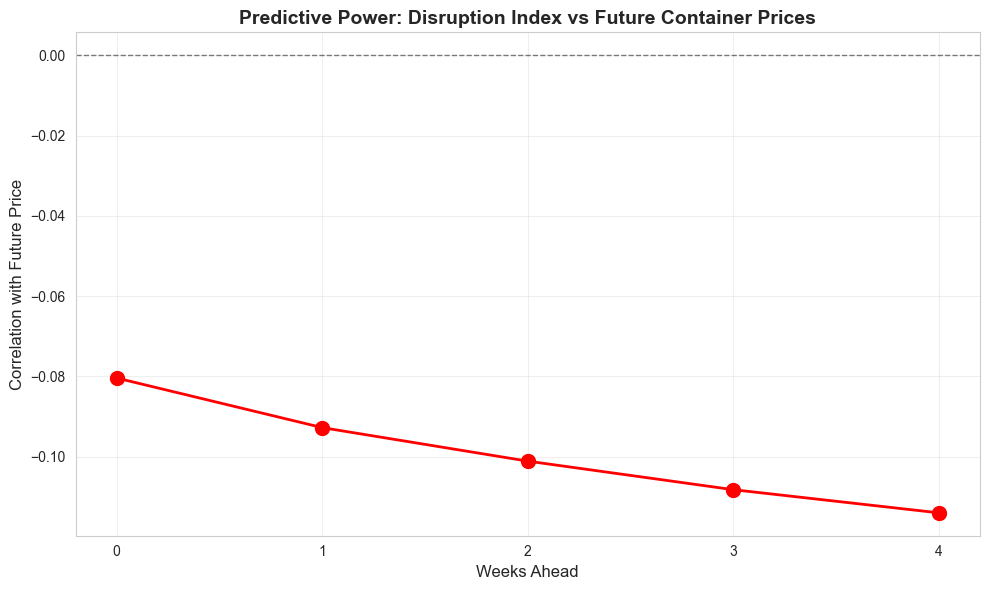


Best correlation is at lag 0 (same week): -0.080
Disruptions and prices move together, but may not be predictive.


In [15]:
if has_news:
    print("=" * 70)
    print("DISRUPTION-PRICE CORRELATION ANALYSIS")
    print("=" * 70)
    
    # Merge freight and disruption data on weekly dates
    # Both datasets should already be weekly aligned (Fridays)
    df_combined = df_freight.join(df_news, how='inner')
    
    print(f"\nCombined dataset: {len(df_combined)} weeks with both freight and disruption data")
    print(f"Date range: {df_combined.index.min().strftime('%Y-%m-%d')} to {df_combined.index.max().strftime('%Y-%m-%d')}")
    
    # Calculate correlation matrix
    disruption_cols = ['disruption_index', 'tone', 'conflict_count', 'severe_event_count', 'media_mentions']
    price_cols = ['Europe_Base_Price', 'SCFI_Index']
    
    correlation_subset = df_combined[price_cols + disruption_cols].corr()
    
    print("\n=== Correlation Matrix ===")
    print(correlation_subset)
    
    # Visualize correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation: Container Prices vs Disruption Indicators', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Focus on Europe Base Price correlations
    print("\n=== Correlation with Europe Base Price ===")
    price_corr = correlation_subset['Europe_Base_Price'][disruption_cols].sort_values(ascending=False)
    print(price_corr)
    
    print("\n=== Interpretation ===")
    for feature, corr_value in price_corr.items():
        if abs(corr_value) > 0.5:
            strength = "STRONG"
        elif abs(corr_value) > 0.3:
            strength = "MODERATE"
        elif abs(corr_value) > 0.1:
            strength = "WEAK"
        else:
            strength = "NEGLIGIBLE"
        
        direction = "positive" if corr_value > 0 else "negative"
        print(f"  {feature}: {strength} {direction} correlation ({corr_value:.3f})")
    
    # Scatter plots: Disruption index vs Price
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter 1: Disruption index vs Europe Base Price
    axes[0].scatter(df_combined['disruption_index'], df_combined['Europe_Base_Price'], 
                   alpha=0.5, s=50, color='red')
    axes[0].set_xlabel('Disruption Index', fontsize=12)
    axes[0].set_ylabel('Europe Base Price (USD)', fontsize=12)
    axes[0].set_title(f'Disruption Index vs Price\nCorrelation: {price_corr["disruption_index"]:.3f}', 
                     fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df_combined['disruption_index'], df_combined['Europe_Base_Price'], 1)
    p = np.poly1d(z)
    axes[0].plot(df_combined['disruption_index'], p(df_combined['disruption_index']), 
                "r--", alpha=0.8, linewidth=2, label='Trend line')
    axes[0].legend()
    
    # Scatter 2: Media tone vs Europe Base Price
    axes[1].scatter(df_combined['tone'], df_combined['Europe_Base_Price'], 
                   alpha=0.5, s=50, color='blue')
    axes[1].set_xlabel('Media Tone (Sentiment)', fontsize=12)
    axes[1].set_ylabel('Europe Base Price (USD)', fontsize=12)
    axes[1].set_title(f'Media Tone vs Price\nCorrelation: {price_corr["tone"]:.3f}', 
                     fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Add trend line
    z2 = np.polyfit(df_combined['tone'], df_combined['Europe_Base_Price'], 1)
    p2 = np.poly1d(z2)
    axes[1].plot(df_combined['tone'], p2(df_combined['tone']), 
                "b--", alpha=0.8, linewidth=2, label='Trend line')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Lagged correlation analysis (check if disruptions predict future prices)
    print("\n" + "=" * 70)
    print("LAGGED CORRELATION ANALYSIS (Do disruptions predict future prices?)")
    print("=" * 70)
    
    lags = [0, 1, 2, 3, 4]  # Check 0-4 week lags
    lag_correlations = {}
    
    for lag in lags:
        if lag == 0:
            lag_corr = df_combined['disruption_index'].corr(df_combined['Europe_Base_Price'])
        else:
            lag_corr = df_combined['disruption_index'].corr(df_combined['Europe_Base_Price'].shift(-lag))
        lag_correlations[lag] = lag_corr
    
    print("\nDisruption index correlation with future prices:")
    for lag, corr in lag_correlations.items():
        if lag == 0:
            print(f"  Same week (lag 0):  {corr:.3f}")
        else:
            print(f"  {lag} week(s) ahead (lag {lag}): {corr:.3f}")
    
    # Plot lagged correlations
    plt.figure(figsize=(10, 6))
    plt.plot(lags, [lag_correlations[lag] for lag in lags], marker='o', markersize=10, 
            linewidth=2, color='red')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('Weeks Ahead', fontsize=12)
    plt.ylabel('Correlation with Future Price', fontsize=12)
    plt.title('Predictive Power: Disruption Index vs Future Container Prices', 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(lags)
    plt.tight_layout()
    plt.show()
    
    # Find optimal lag
    best_lag = max(lag_correlations, key=lag_correlations.get)
    if best_lag == 0:
        print(f"\nBest correlation is at lag 0 (same week): {lag_correlations[best_lag]:.3f}")
        print("Disruptions and prices move together, but may not be predictive.")
    else:
        print(f"\nBest correlation is at lag {best_lag} ({best_lag} week(s) ahead): {lag_correlations[best_lag]:.3f}")
        print(f"This suggests disruptions may help predict prices {best_lag} week(s) in advance.")
    
else:
    print("No GDELT disruption data available for correlation analysis.")

## Step 11: Summary of findings

Let's create a summary of what we learned about our data.

In [ ]:
print("=" * 70)
print("DATA UNDERSTANDING SUMMARY")
print("=" * 70)

print("\n1. Dataset Overview:")
print(f"   - Total weeks of freight data: {len(df_freight)}")
print(f"   - Date range: {df_freight.index.min().strftime('%Y-%m-%d')} to {df_freight.index.max().strftime('%Y-%m-%d')}")
print(f"   - Number of price features: {len(df_freight.columns)}")

print("\n2. Target Variable (Europe Base Price):")
print(f"   - Mean: ${df_freight['Europe_Base_Price'].mean():.2f}")
print(f"   - Range: ${df_freight['Europe_Base_Price'].min():.2f} to ${df_freight['Europe_Base_Price'].max():.2f}")
print(f"   - Volatility (std): ${df_freight['Europe_Base_Price'].std():.2f}")

print("\n3. Data Quality:")
missing_total = df_freight.isnull().sum().sum()
if missing_total == 0:
    print("   - No missing values in freight data")
else:
    print(f"   - Found {missing_total} missing values in freight data")

print("\n4. Volatility Assessment:")
price_range = df_freight['Europe_Base_Price'].max() - df_freight['Europe_Base_Price'].min()
price_volatility = df_freight['Europe_Base_Price'].std() / df_freight['Europe_Base_Price'].mean()
print(f"   - Price range: ${price_range:.2f}")
print(f"   - Coefficient of variation: {price_volatility:.2%}")

if price_volatility > 0.3:
    print("   - Prices show HIGH volatility (good for disruption modeling)")
elif price_volatility > 0.15:
    print("   - Prices show MODERATE volatility")
else:
    print("   - Prices show LOW volatility")

print("\n5. External Data Sources:")
if has_oil:
    print(f"   Available: Oil price data: {len(df_oil)} days")
else:
    print("   Not available: Oil price data: Not available")

if has_news:
    print(f"   Available: GDELT disruption data: {len(df_news)} weeks")
    print(f"     - Disruption index range: {df_news['disruption_index'].min():.3f} to {df_news['disruption_index'].max():.3f}")
    print(f"     - Total conflict events: {df_news['conflict_count'].sum():.0f}")
    print(f"     - Total severe events: {df_news['severe_event_count'].sum():.0f}")
    
    # Show correlation if data was merged
    try:
        if 'df_combined' in locals():
            disruption_corr = df_combined['Europe_Base_Price'].corr(df_combined['disruption_index'])
            print(f"     - Correlation with prices: {disruption_corr:.3f}")
    except:
        pass
else:
    print("   Not available: GDELT disruption data: Not available")

print("\n6. Key Observations:")
print("   - Time series data suitable for sequential modeling (LSTM, GRU)")
print("   - Weekly frequency matches business planning cycles")
if has_news:
    print("   - Geopolitical disruption features available for black swan detection")
    print("   - Multiple disruption indicators (conflicts, sentiment, media volume)")

print("\n7. Next Steps:")
print("   - Proceed to data preparation notebook (03_data_preparation.ipynb)")
print("   - Create lag features from disruption indicators")
print("   - Merge all data sources on weekly alignment")
print("   - Prepare training/test splits for 1-week ahead prediction")
print("   - Engineer additional features (rolling averages, price changes, etc.)")

print("\n" + "=" * 70)

DATA UNDERSTANDING SUMMARY

1. Dataset Overview:
   - Total weeks of freight data: 385
   - Date range: 2018-01-05 to 2025-08-22
   - Number of price features: 2

2. Target Variable (Europe Base Price):
   - Mean: $2481.80
   - Range: $562.00 to $7797.00
   - Volatility (std): $2258.17

3. Data Quality:
   - No missing values in freight data

4. Volatility Assessment:
   - Price range: $7235.00
   - Coefficient of variation: 90.99%
   - Prices show HIGH volatility (good for disruption modeling)

5. External Data Sources:
   ✓ Oil price data: 2787 days
   ✓ GDELT disruption data: 412 weeks
     - Disruption index range: 1.703 to 687.690
     - Total conflict events: 28908617
     - Total severe events: 12912294
     - Correlation with prices: -0.080

6. Key Observations:
   - Time series data suitable for sequential modeling (LSTM, GRU)
   - Weekly frequency matches business planning cycles
   - Geopolitical disruption features available for black swan detection
   - Multiple disruption